# А/B тестироване


В распоряжении датасет для A/B-тестирования - это синтетический набор данных, сгенерированный с использованием техники случайной выборки из библиотеки NumPy. Датасет имитирует информацию о посещениях пользователями розничного веб-сайта, работающего по всей Великобритании. <br>
Пользователи разделены на две группы - группа А (контрольная) и группа В (тестовая). <br>
представим, что компания хочет протестировать следующее изменение на сайте: изменить цвет фона с белого на черный и проверить, как данное изменение повлияет на время, которое пользователи проводят на сайте, количество страниц, которое просматривают и конверсию. <br>
Этот вопрос ставится для достижения основной цели анализа - повышения вовлеченности пользователей. <br>
В данном случае: <br>
- Белый цвет присваивается группе А, как фоновый цвет страницы
- Черный цвет присваивается группе В, как фоновый цвет страницы


### Цель <br>
Целью анализа является выявление того, является ли статистически значимым увеличение просмотров страницы, время, провеленное на странице и конверсия, если применить новое оформление. Для этого проведем А/B тестирование

### Задачи 
- Подготовка данных 
- Анализ результатов A/B тестирования
- Выводы

### Описание столбцов <br>
- User ID: Уникальный идентификатор пользователя  
- Group: Указывает на группу — контрольная (A) или тестовая (B)   
- Page Views: Количество просмотренных страниц за сессию  
- Time Spent: Общее время (в секундах), проведённое пользователем на сайте  
- Conversion: Завершил ли пользователь целевое действие (Да/Нет)  
- Device: Тип устройства, с которого пользователь зашёл на сайт 
- Location: Регион в Великобритании, где находится пользователь

### Импорт необходимых библиотек и обзор данных

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = pd.read_csv('ab_testing.csv')

In [40]:
data.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


Для удобства переименуем столбцы и сделаем все буквы строчными

In [41]:
data.isna().sum()

User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

Датасет не содержит пропусков

## Предобработка данных

Приведем названия столбцов в удобный вид для дальнейшей работы (уберем пробелы и все буквы сделаем строчными)

In [42]:
def name_col(col):
    return '_'.join(col.lower().split(' '))
new_cols = []
for col in data.columns:
    new_cols.append(name_col(col))

data.columns = new_cols


Заменим значение в столбце conversion на 1 (Yes) и 0 (No)

In [43]:
data['conversion']=data['conversion'].apply(lambda x: 1 if x=='Yes' else 0)

In [44]:
data

,user_id,group,page_views,time_spent,conversion,device,location
0,14292,B,3,424,0,Mobile,Northern Ireland
1,11682,A,9,342,0,Mobile,Scotland
2,19825,A,2,396,0,Desktop,Northern Ireland
3,16080,B,4,318,0,Desktop,Wales
4,18851,A,1,338,1,Desktop,Scotland
...,...,...,...,...,...,...,...
4995,16360,B,12,313,0,Mobile,Wales
4996,18084,B,10,313,0,Desktop,Northern Ireland
4997,12063,A,11,156,0,Desktop,England
4998,18647,B,13,346,0,Desktop,Wales


In [69]:
data['group'].value_counts()

group
A    2519
B    2481
Name: count, dtype: int64

## Анализ результатов А/В тестирования

### Анализ различий конверсии между группами А и В

Сформулируем гипотезы: <br>
Н0: Изменение оформления никак не повляет на конверсию <br>
Н1: Изменение оформления поспособствует увеличению конверсии

Рассчитаем минимальный детектируемый эффект (MDE), чтобы понимать, добились ли мы необходимых различий в конверсии обеих групп

In [67]:
from statsmodels.stats.power import NormalIndPower
import numpy as np


alpha = 0.05  # Уровень значимости
power = 0.8   # Мощность теста


group_A = data[data['group'] == 'A']['conversion']
group_B = data[data['group'] == 'B']['conversion']


pooled_std = np.sqrt((group_A.var() + group_B.var()) / 2)


n = min(len(group_A), len(group_B))  

analysis = NormalIndPower()
effect_size = analysis.solve_power(nobs1=n, alpha=alpha, power=power, ratio=1, alternative='two-sided')

# Переводим в метрику Conversion
mde_views = effect_size * pooled_std

print(f'Минимальный детектируемый эффект (MDE) по конверсии: {mde_views:.2f} %')


Минимальный детектируемый эффект (MDE) по page views: 0.02 %


Построим для начала таблицу со значениями конверсий для каждой из групп

In [45]:
round(pd.crosstab(data['group'], data['conversion'], normalize='index'),4) *100

conversion,0,1
group,,
A,94.60,5.40
B,85.93,14.07


Из полученных результатов видно, что конверсия группы __А__ составила 5.40 %, а конверсия группы __В__ - 14.07. Значит прирост (uplift) составил __8.67 процентных пункта__ или 8.67/5.40 = __160.6 %__. Полученный результат превысил MDE, значит, можно продолжить дальнейший анализ 

Проанализируем статистическую значимость полученных результатов и на основе этого уже принимать или отвергать нулевую гипотезу Н0. Для этого будет использован Z-test, с помощью которого удастся определить значение p-value (вероятность получить такие или еще более выраженные различия). Установим опорное значение p-value = 0.05, что значит, если полученное значение p-value будет меньше 0.05, то увеличение конверсии в группе В является статичтически значимым, а, следовательно, мы можем отвергнуть нулевую гипотезу и сделать вывод, что новое оформление действительно положительно влияет на конверсию

In [50]:
from statsmodels.stats.proportion import proportions_ztest

converted_A = data[(data['group']=='A') & (data['conversion']==1)].shape[0] # число успешных конверсий в группе А
converted_B = data[(data['group'] == 'B') & (data['conversion']==1)].shape[0] # число успешных конверсий в группе В

total_A = data[data['group']=='A'].shape[0] # общее число наблюдений в группе А
total_B = data[data['group']=='B'].shape[0] # общее число наблюдений в группе В

success = [converted_A, converted_B]
total = [total_A, total_B]

z_stat, p_val = proportions_ztest(success, total)

print(f'z-stat: {z_stat}')
print(f'p-value: {p_val:}')

z-stat: -10.354488520266216
p-value: 3.9931511894201938e-25


Значение p-value не привысило 0.05 (3.99*10^-25<0.05), следовательно мы можем отвергнуть нулевую гипотезу и сделать заключение о статистической значимости полученных изменений. Однако лучше также проверить влияние и вклад различных факторов на увеличение конверсии, например, платформы, с которой просматривалась страница или страны.

Рассчитаем 95% доверительный интервал

In [78]:
import statsmodels.api as sm

# Количество конверсий и общее количество пользователей в группе A
successes_A = data[(data['group']=='A') & (data['conversion']==1)].shape[0]
nobs_A = data[data['group']=='A'].shape[0]

# Построение доверительного интервала
ci_low_A, ci_upp_A = sm.stats.proportion_confint(count=successes_A, nobs=nobs_A, alpha=0.05, method='normal')

print(f"Доверительный интервал для группы A: ({ci_low_A:.4f}, {ci_upp_A:.4f})")

# Количество конверсий и общее количество пользователей в группе B
successes_B = data[(data['group']=='B') & (data['conversion']==1)].shape[0]
nobs_B = data[data['group']=='B'].shape[0]

# Построение доверительного интервала
ci_low_B, ci_upp_B = sm.stats.proportion_confint(count=successes_B, nobs=nobs_B, alpha=0.05, method='normal')

print(f"Доверительный интервал для группы B: ({ci_low_B:.4f}, {ci_upp_B:.4f})")



Доверительный интервал для группы A: (0.0452, 0.0628)
Доверительный интервал для группы B: (0.1270, 0.1543)


"Конверсия группы A составляет 5.4% (95% CI: 4.5% — 6.3%)"

"Конверсия группы B составляет 14.07% (95% CI: 12.5% — 15.7%)"

#### Сегментный анализ 

Проверим, обуслувлены ли различия в конверсии дополнительными факторами, такими как устройство пользователя (device) или его географическое местоположение (location).  
Для этого проведём **тесты хи-квадрат независимости**, чтобы проверить наличие статистически значимой связи между конверсией и указанными признаками.

In [52]:
from scipy.stats import chi2_contingency
import pandas as pd

# Примерная таблица сопряженности
table = pd.crosstab(data['device'], data['conversion'])

chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2 Statistic: {chi2}")
print(f"P-Value: {p}")


Chi2 Statistic: 0.3642000562330795
P-Value: 0.5461828342638735


p-value больше уровня значимости 0.05, следовательно, мы не можем говорить о статистически значимом влиянии девайса на конверсию

In [53]:
from scipy.stats import chi2_contingency
import pandas as pd

# Примерная таблица сопряженности
table = pd.crosstab(data['location'], data['conversion'])

chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2 Statistic: {chi2}")
print(f"P-Value: {p}")


Chi2 Statistic: 4.9349148365909015
P-Value: 0.17662550981879305


p-value больше уровня значимости 0.05, следовательно, мы не можем говорить о статистически значимом влиянии локации на конверсию

Проведённый сегментный анализ показывает, что **ни устройство, ни географическое местоположение пользователя не влияют на конверсию**. Следовательно, выявленные различия между группами **не могут быть объяснены эффектами устройств или регионов**.

### Анализ различий времени (в секундах), проведенных на сайте, между группами А и B

Сформулируем гипотезы: <br>
Н0: Изменение оформления никак не повляет на среднее время, которое пользователи проводят на сайте <br>
Н1: Изменение оформления поспособствует увеличению среднего времени, проводимом на сайте

Посмотрим на распределение данных о времени, которое пользователи проводят на сайте

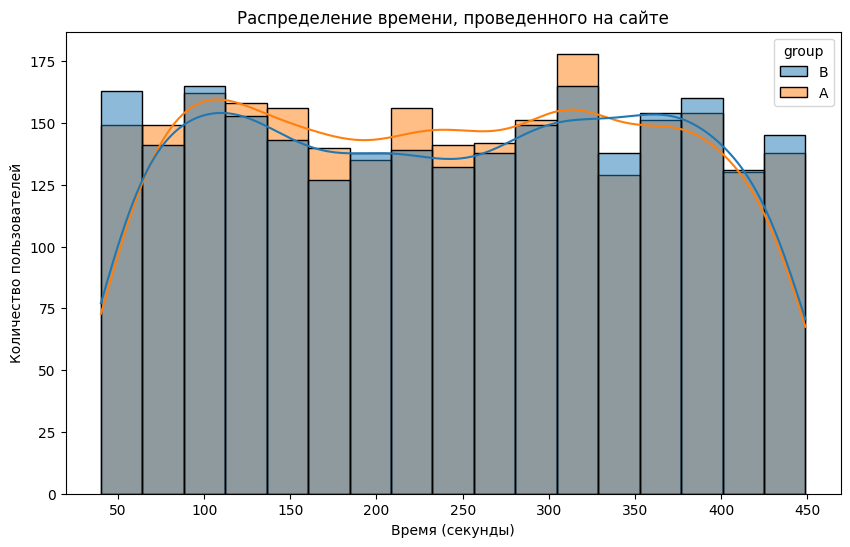

In [72]:

plt.figure(figsize=(10,6))
sns.histplot(data=data, x='time_spent', hue='group', kde=True)
plt.title('Распределение времени, проведенного на сайте')
plt.xlabel('Время (секунды)')
plt.ylabel('Количество пользователей')
plt.show()


Рассчитаем минимальный детектируемый эффект (MDE), чтобы понимать, добились ли мы необходимых различий в конверсии обеих групп

In [61]:
from statsmodels.stats.power import NormalIndPower
import numpy as np

# Параметры
alpha = 0.05  # Уровень значимости
power = 0.8   # Мощность теста


group_A = data[data['group'] == 'A']['time_spent']
group_B = data[data['group'] == 'B']['time_spent']


pooled_std = np.sqrt((group_A.var() + group_B.var()) / 2)


n = min(len(group_A), len(group_B))  


analysis = NormalIndPower()
effect_size = analysis.solve_power(nobs1=n, alpha=alpha, power=power, ratio=1, alternative='two-sided')


mde_views = effect_size * pooled_std

print(f'Минимальный детектируемый эффект (MDE) по time spent: {mde_views:.2f} секунд')


Минимальный детектируемый эффект (MDE) по time spent: 9.41 секунд


In [58]:
# Для time_spent
mean_time_spent_A = data[data['group'] == 'A']['time_spent'].mean()
mean_time_spent_B = data[data['group'] == 'B']['time_spent'].mean()

print(f'Среднее время на сайте для группы A: {mean_time_spent_A:.2f} секунд')
print(f'Среднее время на сайте для группы B: {mean_time_spent_B:.2f} секунд')

Среднее время на сайте для группы A: 241.73 секунд
Среднее время на сайте для группы B: 243.30 секунд


Из полученных результатов видно, что среднее время, которое пользователи проводят на сайте увеличилось на 1.57 секунды, что меньше MDE (1.57<9.41)
Это означает, что:
- Даже если статистические тесты показали бы значимость (маленький p-value), **различие настолько мало, что оно не имеет практической ценности** для бизнеса.
- Мы **не можем с уверенностью утверждать**, что наблюдаемое различие представляет собой реальное улучшение метрики, а не просто случайные колебания.

### Анализ различий количества просмотренных страниц, проведенных на сайте, между группами А и B

Сформулируем гипотезы: <br>
Н0: Изменение оформления никак не повляет на среднее количество страниц, просматриваемых пользователями <br>
Н1: Изменение оформления поспособствует увеличению среднего количества страниц, просматриваемых пользователями 

Посмотрим на распределение данных о количестве страниц, посещаемых пользователями

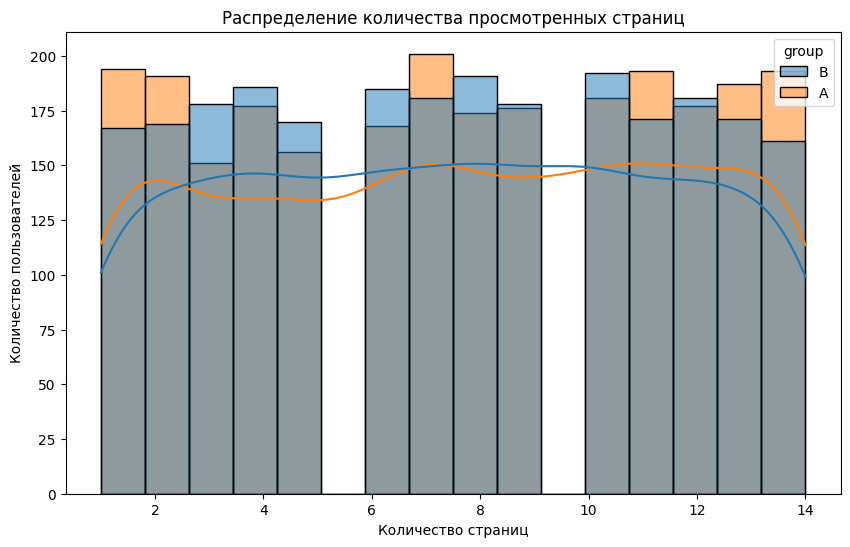

In [76]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='page_views', hue='group', kde=True)
plt.title('Распределение количества просмотренных страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Количество пользователей')
plt.show()

In [60]:
from statsmodels.stats.power import NormalIndPower
import numpy as np

# Параметры
alpha = 0.05  # Уровень значимости
power = 0.8   # Мощность теста


group_A = data[data['group'] == 'A']['page_views']
group_B = data[data['group'] == 'B']['page_views']


pooled_std = np.sqrt((group_A.var() + group_B.var()) / 2)


n = min(len(group_A), len(group_B))  


analysis = NormalIndPower()
effect_size = analysis.solve_power(nobs1=n, alpha=alpha, power=power, ratio=1, alternative='two-sided')


mde_views = effect_size * pooled_std

print(f'Минимальный детектируемый эффект (MDE) по page views: {mde_views:.2f} страниц')


Минимальный детектируемый эффект (MDE) по page views: 0.32 страниц


In [59]:

mean_page_views_A = data[data['group'] == 'A']['page_views'].mean()
mean_page_views_B = data[data['group'] == 'B']['page_views'].mean()

print(f'Среднее количество просмотренных страниц для группы A: {mean_page_views_A:.2f}')
print(f'Среднее количество просмотренных страниц для группы B: {mean_page_views_B:.2f}')

Среднее количество просмотренных страниц для группы A: 7.58
Среднее количество просмотренных страниц для группы B: 7.49


Из полученных результатов видно, что среднее количество страниц, просматриваемых пользователями уменьшилось на 0.9 страницы, что меньше MDE (0.9<0.32)
Это означает, что:
- Даже если статистические тесты показали бы значимость (маленький p-value), **различие настолько мало, что оно не имеет практической ценности** для бизнеса.
- Мы **не можем с уверенностью утверждать**, что наблюдаемое различие представляет собой реальное улучшение метрики, а не просто случайные колебания.

## Вывод

По результатам тестирования удалось выявить статистически значимое увеличение конверсии (прирост на 8.67 процентных пункта). Это изменение преодолело порог минимального детектируемого эффекта (MDE) и имеет практическую ценность для бизнеса. Существенных улучшений по остальным метрикам (количество просмотренных страниц, время на сайте) выявлено не было: различия оказались ниже MDE и не значимы для бизнеса. На основании полученных данных рекомендуется внедрить новое оформление сайта для увеличения конверсии.